In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
%matplotlib inline

In [2]:
SOM_WIDTH = 40
SOM_HEIGHT = 40
SOM_LEN = SOM_WIDTH * SOM_HEIGHT
NUM_INPUTS = 4

In [3]:
# load training data
iris_input = np.genfromtxt('iris.data.txt', delimiter='\t', skip_header=1, dtype=np.float64, usecols=(0, 1, 2, 3))
iris_output = np.genfromtxt('iris.data.txt', delimiter='\t', skip_header=1, dtype=str, usecols=(4,))
INPUT_LEN = len(iris_input)

In [4]:
# map weights (internal representation is 1D and converted to 2D only for visualization)
weights = tf.Variable(tf.random_uniform([SOM_LEN, NUM_INPUTS], minval=-1.0, maxval=1.0, dtype=tf.float64), name='weights')

In [5]:
# radius of neighboorhood affected by weights adjustment
radius = tf.placeholder(tf.float64, [1], name='radius')

# learning rate
alpha = tf.placeholder(tf.float64, [1], name='alpha')

In [6]:
# map nodes indices used in 1D->2D conversion
nodes = tf.reshape(tf.transpose(tf.constant(np.indices((SOM_HEIGHT, SOM_WIDTH))), perm=[1, 2, 0]), [SOM_LEN, 2])

In [7]:
def to2d(x):
    return [x // SOM_WIDTH, x % SOM_WIDTH]

In [8]:
def to1d(h, w):
    return h * SOM_WIDTH + w

In [9]:
random_index = tf.random_uniform([1], minval=0, maxval=INPUT_LEN, dtype=tf.int32)
data_vector = tf.gather(iris_input, random_index)
x = tf.expand_dims(tf.transpose(data_vector), 0)
w = tf.expand_dims(weights, 2)

# distance from map nodes to input vectors
dist = tf.sqrt(tf.reduce_sum(tf.squared_difference(data_vector, w), reduction_indices=[1, 2]), 'dist')
print(x.get_shape())
print(w.get_shape())

# best matching unit (BMU) index
bmu = tf.argmin(dist, 0, name='bmu')

# map in 2D
weights2d = tf.reshape(weights, [SOM_HEIGHT, SOM_WIDTH, NUM_INPUTS])

(1, 4, 1)
(1600, 4, 1)


In [10]:
# BMU coordinates in 2D
bmuc = tf.convert_to_tensor(to2d(bmu))

# distance from map nodes to BMU
distance_to_bmu = tf.sqrt(tf.reduce_sum(tf.cast(tf.squared_difference(bmuc, nodes), dtype=tf.float64), reduction_indices=[1]))
distance_to_bmu2d = tf.reshape(distance_to_bmu, [SOM_HEIGHT, SOM_WIDTH])

# neighbourhood function (how map nodes will be affected by weights adjustment)
nf = tf.maximum(-(distance_to_bmu - radius) / radius, 0)
nf2d = tf.reshape(nf, [SOM_HEIGHT, SOM_WIDTH])

In [11]:
adjusted = weights + tf.expand_dims(nf, 1) * tf.expand_dims(alpha, 1) * (data_vector - weights)
adj2d = tf.reshape(adjusted, [SOM_HEIGHT, SOM_WIDTH, NUM_INPUTS])
adjust = tf.assign(weights, adjusted)

In [12]:
xe = tf.expand_dims(tf.transpose(iris_input), 0)
de = tf.argmin(tf.sqrt(tf.reduce_sum(tf.squared_difference(xe, w), reduction_indices=[1])), 0)
print(de.get_shape())
de2d = tf.transpose(tf.pack(to2d(de)))
print(de2d.get_shape())
# average quantization error
aqe = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.squared_difference(iris_input, tf.gather(weights, de)), 1)))

(150,)
(150, 2)


In [13]:
INITIAL_RADIUS = 60
MAX_ITERATIONS = 300
ALPHA = 0.1
RADIUS_DECAY_FACTOR = 2  # radius is r / e^2 at t = MAX_ITERATIONS

In [14]:
def adjacent(x):
    h, w = to2d(x)
    nn = ((-1, -1), (-1, 0), (-1, 1),
          ( 0, -1),          ( 0, 1),
          ( 1, -1), ( 1, 0), ( 1, 1))
    neighbours = ((h + i[0], w + i[1]) for i in nn)
    # resolve edge cases
    filtered_neighbours = filter(lambda x: x[0]>=0 and x[1]>=0 and x[0]<SOM_HEIGHT and x[1]<SOM_WIDTH, neighbours)
    return np.array([to1d(a, b) for a, b in filtered_neighbours])

In [15]:
node = tf.placeholder(tf.int32, shape=[])
neighbours = tf.placeholder(tf.int32, shape=[None])
nodew = weights[node]
umatrix_avg_dist = tf.reduce_mean(tf.reduce_sum(tf.squared_difference(nodew, tf.gather(weights, neighbours)), reduction_indices=[1]))

In [19]:
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    for t in range(MAX_ITERATIONS):
        values = {
            radius: [INITIAL_RADIUS * math.exp(-t / MAX_ITERATIONS * RADIUS_DECAY_FACTOR)], 
            alpha: [ALPHA]
        }
        session.run(adjust, feed_dict=values)

    print('average quantization error: ', session.run(aqe))
    dd = session.run(de2d)
    w1 = session.run(weights2d)
    
    ul = []
    for i in range(SOM_HEIGHT):
        for j in range(SOM_WIDTH):
            n = to1d(i, j)
            ul.append(session.run(umatrix_avg_dist, feed_dict={node: n, neighbours: adjacent(n)}))
    umatrix = np.array(ul).reshape((SOM_WIDTH, SOM_HEIGHT))

average quantization error:  0.49359229209


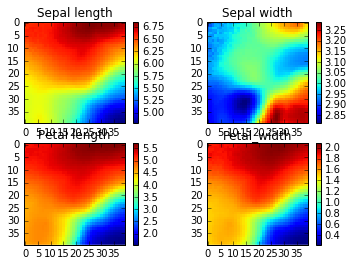

In [20]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 2)

titles = [
    'Sepal length',
    'Sepal width',
    'Petal length',
    'Petal_width'
]

for i in range(2):
    for j in range(2):
        k = i * 2 + j
        a = plt.subplot(gs[i, j])
        fig.add_subplot(a)
        plt.title(titles[k])
        plt.imshow(w1[:,:,k], interpolation='none')
        plt.colorbar()

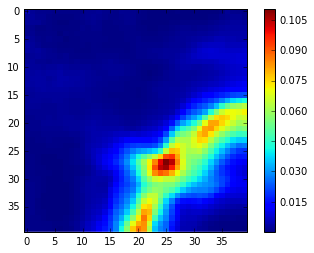

In [21]:
plt.imshow(umatrix, interpolation='none')
plt.colorbar()